# **Regression**

In [1]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# **xLSTM Class (v 1.0)**

In [2]:
# Version 1.0
# Define sLSTM Cell
class sLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(sLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size, 4 * hidden_size) # W(4 * hidden_size, input_size) and b(4 * hidden_size)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size) # So on

    def forward(self, x, hidden):
        h, c = hidden
        # Combine them into a single matrix multiplication
        gates = self.i2h(x) + self.h2h(h) # x(batch_size, input_size)
        i, f, o, g = gates.chunk(4, 1)
        i, f, o, g = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o), torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, (h_next, c_next)

# Define mLSTM Cell
class mLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(mLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.Wq = nn.Linear(input_size, hidden_size)
        self.Wk = nn.Linear(input_size, hidden_size)
        self.Wv = nn.Linear(input_size, hidden_size)
        self.i_gate = nn.Linear(input_size, hidden_size)
        self.f_gate = nn.Linear(input_size, hidden_size)
        self.o_gate = nn.Linear(input_size, hidden_size)
        self.bf = nn.Parameter(torch.zeros(hidden_size)) # Learnable bias for the forget gate

    def forward(self, x, hidden):
        C, n = hidden
        query = self.Wq(x)
        key = self.Wk(x) / (self.hidden_size ** 0.5)
        value = self.Wv(x)

        i = torch.sigmoid(self.i_gate(x))
        f = torch.sigmoid(self.f_gate(x) + self.bf)
        o = torch.sigmoid(self.o_gate(x))

        C_next = f * C + i * value
        n_next = f * n + i * key

        # Uses the query vector to retrieve relevant information from memory (C_next)
        retrieval = torch.sum(C_next * query, dim=1, keepdim=True)
        h_next = o * torch.tanh(retrieval)

        # Updated hidden state and memory
        return h_next, (C_next, n_next)

class xLSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, layer_types):
        super(xLSTMBlock, self).__init__()
        self.layers = nn.ModuleList()
        for i, layer_type in enumerate(layer_types):
            if layer_type == 'sLSTM':
                self.layers.append(sLSTMCell(input_size if i == 0 else hidden_size, hidden_size))
            elif layer_type == 'mLSTM':
                self.layers.append(mLSTMCell(input_size if i == 0 else hidden_size, hidden_size))

    def forward(self, x, hidden):
        seq_len, batch_size, _ = x.size() # x(seq_len, batch_size, input_size)
        h, c = list(torch.unbind(hidden[0], dim=0)), list(torch.unbind(hidden[1], dim=0)) # h,c(batch_size, hidden_size)
        outputs = []

        for t in range(seq_len):
            input_t = x[t] # (batch_size, input_size)
            for layer_idx, layer in enumerate(self.layers):
                """
                  Current time step and hidden states for the current layer are passed
                  to the layer (either sLSTM or mLSTM).
                  h_next: Updated hidden state for the current layer and time step
                  (C_next, n_next): Updated cell state (memory) for the layer and time step
                """
                h_next, (C_next, n_next) = layer(input_t, (h[layer_idx], c[layer_idx]))
                h[layer_idx], c[layer_idx] = h_next, C_next
                input_t = h_next

            # The hidden state of the last layer append it to the list
            outputs.append(h[-1])

        outputs = torch.stack(outputs, dim=0) # (seq_len, batch_size, hidden_size)
        h = torch.stack(h, dim=0) # (num_layers, batch_size, hidden_size)
        c = torch.stack(c, dim=0) # So on
        return outputs, (h, c)

# Define Model
class xLSTMForecastModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, layer_types):
        super(xLSTMForecastModel, self).__init__()
        self.xlstm = xLSTMBlock(input_size, hidden_size, num_layers, layer_types)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        output, hidden = self.xlstm(x, hidden)
        output = self.fc(output[-1])
        return output, hidden

# **Functions**

In [3]:
def spliter(data, size):
    x, y = [], []
    for i in range(len(data) - size):
        x.append(data[i: i + size, 0])
        y.append(data[i + size, 0])
    x = np.array(x)
    y = np.array(y)
    x = x[..., np.newaxis]
    return x, y

# **Parameters and other**

In [4]:
# Parameters
length = 50
batch_size = 8
epochs = 100
learning_rate = 0.001
input_size = 1
hidden_size = 8
num_layers = 4
output_size = 1
layer_types = ["sLSTM", "mLSTM", "sLSTM", "mLSTM"]

In [5]:
# Data Preprocessing
btc_data = pd.read_csv('your_dataset.csv')
close_price = btc_data["Close"].values
scaler = MinMaxScaler(feature_range=(0, 1))
close_price = scaler.fit_transform(close_price.reshape(-1, 1))

In [6]:
train_size = int(len(close_price) * 0.8)
X_train, X_test = close_price[:train_size], close_price[train_size:]
x_train, y_train = spliter(X_train, length)
x_test, y_test = spliter(X_test, length)

x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

In [7]:
model = xLSTMForecastModel(input_size, hidden_size, num_layers, output_size, layer_types)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

Epoch 1/100, Training Loss: 0.0309, Testing Loss: 0.0158, MSE: 0.0159, MAE: 0.0990, RMSE: 0.1259
Epoch 2/100, Training Loss: 0.0010, Testing Loss: 0.0027, MSE: 0.0027, MAE: 0.0352, RMSE: 0.0524
Epoch 3/100, Training Loss: 0.0004, Testing Loss: 0.0018, MSE: 0.0019, MAE: 0.0294, RMSE: 0.0432
Epoch 4/100, Training Loss: 0.0004, Testing Loss: 0.0020, MSE: 0.0020, MAE: 0.0318, RMSE: 0.0451
Epoch 5/100, Training Loss: 0.0004, Testing Loss: 0.0016, MSE: 0.0016, MAE: 0.0325, RMSE: 0.0404
Epoch 6/100, Training Loss: 0.0004, Testing Loss: 0.0008, MSE: 0.0008, MAE: 0.0207, RMSE: 0.0288
Epoch 7/100, Training Loss: 0.0003, Testing Loss: 0.0010, MSE: 0.0010, MAE: 0.0232, RMSE: 0.0313
Epoch 8/100, Training Loss: 0.0004, Testing Loss: 0.0023, MSE: 0.0023, MAE: 0.0353, RMSE: 0.0485
Epoch 9/100, Training Loss: 0.0003, Testing Loss: 0.0010, MSE: 0.0010, MAE: 0.0214, RMSE: 0.0316
Epoch 10/100, Training Loss: 0.0003, Testing Loss: 0.0008, MSE: 0.0009, MAE: 0.0198, RMSE: 0.0293
Epoch 11/100, Training Loss: 

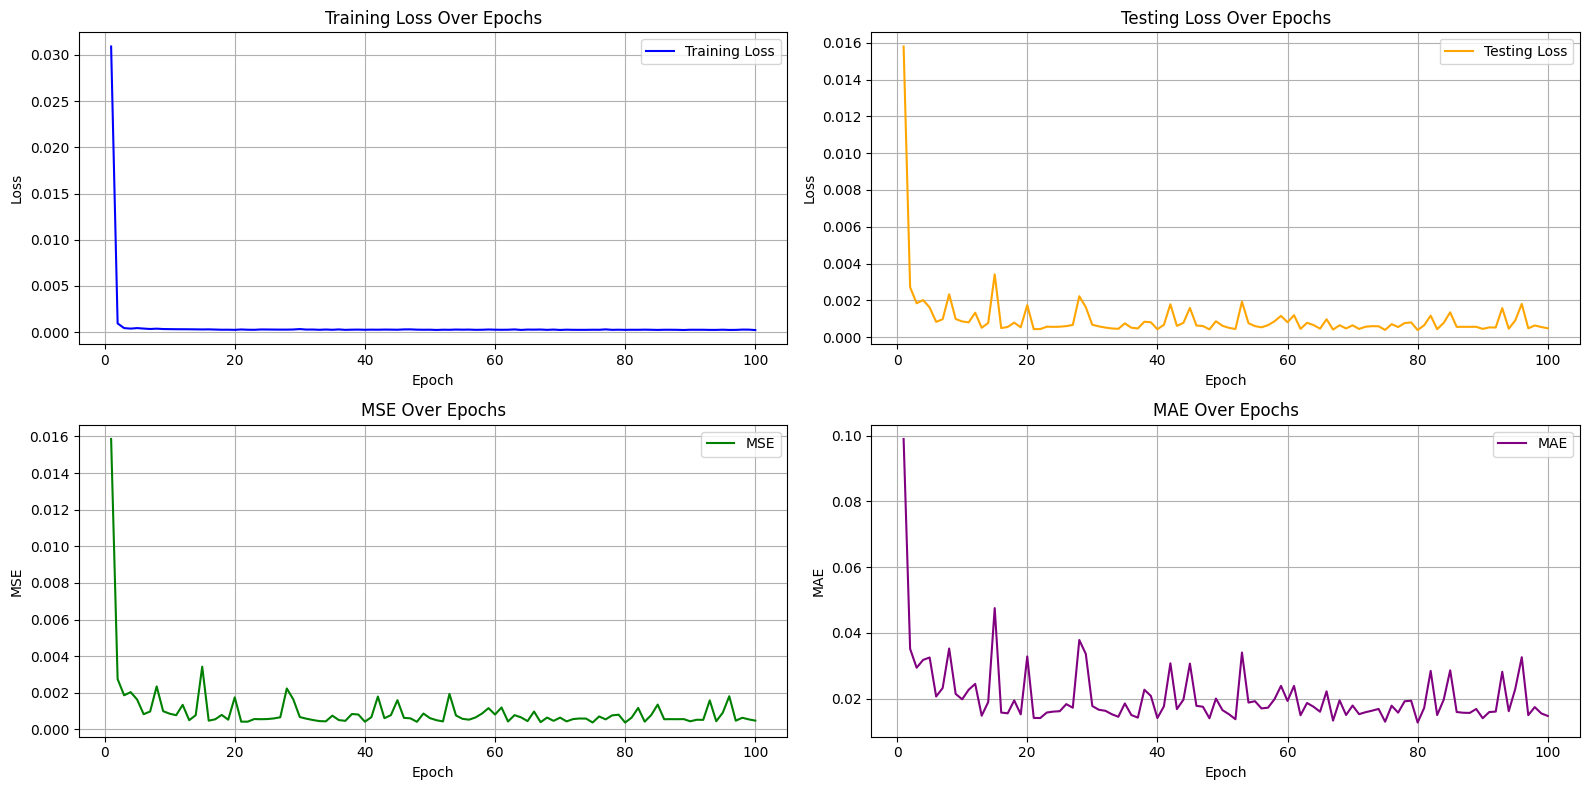

In [8]:
# Training Loop
train_losses = []
test_losses = []
mse_per_epoch = []
mae_per_epoch = []
rmse_per_epoch = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for seq, target in train_loader:
        batch_size = seq.size(0)
        h = torch.zeros(num_layers, batch_size, hidden_size)
        c = torch.zeros(num_layers, batch_size, hidden_size)
        seq = seq.permute(1, 0, 2)
        optimizer.zero_grad()
        pred, _ = model(seq, (h, c))
        loss = criterion(pred.squeeze(), target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    total_test_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for seq, target in test_loader:
            batch_size = seq.size(0)
            h = torch.zeros(num_layers, batch_size, hidden_size)
            c = torch.zeros(num_layers, batch_size, hidden_size)
            seq = seq.permute(1, 0, 2)
            pred, _ = model(seq, (h, c))
            loss = criterion(pred.squeeze(), target)
            total_test_loss += loss.item()
            val_preds.extend(pred.squeeze().tolist())
            val_labels.extend(target.tolist())
    test_loss = total_test_loss / len(test_loader)
    test_losses.append(test_loss)

    val_preds = np.array(val_preds)
    val_labels = np.array(val_labels)
    mse = mean_squared_error(val_labels, val_preds)
    mae = mean_absolute_error(val_labels, val_preds)
    rmse = np.sqrt(mse)

    mse_per_epoch.append(mse)
    mae_per_epoch.append(mae)
    rmse_per_epoch.append(rmse)

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Plot Metrics
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, train_losses, label="Training Loss", color="blue")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(epochs_range, test_losses, label="Testing Loss", color="orange")
plt.title("Testing Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(epochs_range, mse_per_epoch, label="MSE", color="green")
plt.title("MSE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(epochs_range, mae_per_epoch, label="MAE", color="purple")
plt.title("MAE Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# **Plotting**

Training RMSE: 1125.9790430536436
Training MSE: 1267828.805395999
Training MAE: 761.6063210248794


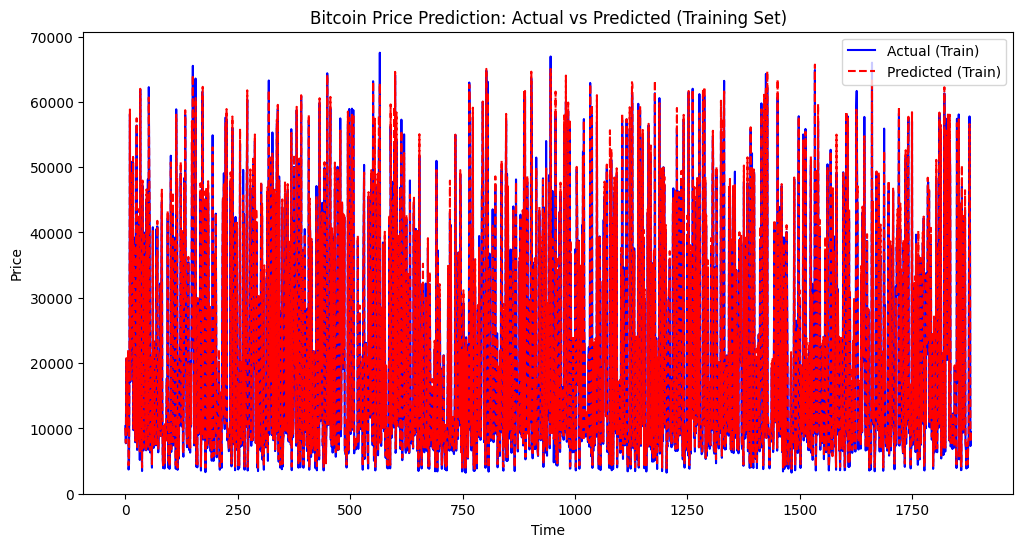

In [ ]:
# Evaluation and Visualization
model.eval()
train_predictions = []
train_actuals = []

with torch.no_grad():
    for seq, target in train_loader:
        batch_size = seq.size(0)
        h = torch.zeros(num_layers, batch_size, hidden_size)
        c = torch.zeros(num_layers, batch_size, hidden_size)
        seq = seq.permute(1, 0, 2)
        pred, _ = model(seq, (h, c))
        train_predictions.extend(pred.squeeze().tolist())
        train_actuals.extend(target.tolist())

train_predictions = scaler.inverse_transform(np.array(train_predictions).reshape(-1, 1))
train_actuals = scaler.inverse_transform(np.array(train_actuals).reshape(-1, 1))

# Calculate metrics for training set
train_rmse = math.sqrt(mean_squared_error(train_actuals, train_predictions))
train_mse = mean_squared_error(train_actuals, train_predictions)
train_mae = mean_absolute_error(train_actuals, train_predictions)

print(f"Training RMSE: {train_rmse}")
print(f"Training MSE: {train_mse}")
print(f"Training MAE: {train_mae}")

# Plot training predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(train_actuals, label="Actual (Train)", color="blue")
plt.plot(train_predictions, label="Predicted (Train)", color="red", linestyle="dashed")
plt.legend()
plt.title("Bitcoin Price Prediction: Actual vs Predicted (Training Set)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

Testing RMSE: 1532.645645197805
Testing MSE: 2349002.673743796
Testing MAE: 1029.182512553386


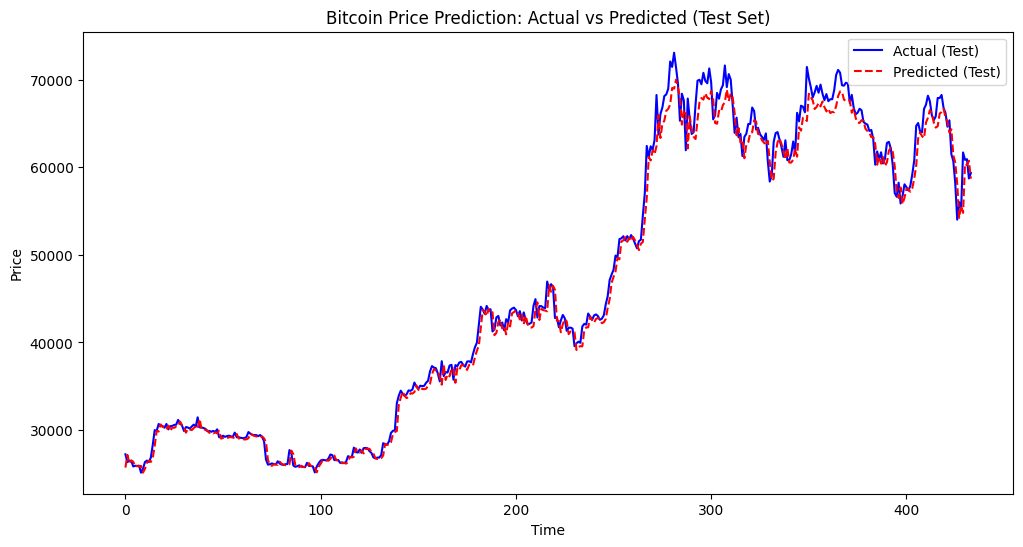

In [9]:
# Evaluation on test set
predictions = []
actuals = []

with torch.no_grad():
    for seq, target in test_loader:
        batch_size = seq.size(0)
        h = torch.zeros(num_layers, batch_size, hidden_size)
        c = torch.zeros(num_layers, batch_size, hidden_size)
        seq = seq.permute(1, 0, 2)
        pred, _ = model(seq, (h, c))
        predictions.extend(pred.squeeze().tolist())
        actuals.extend(target.tolist())

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Calculate metrics for test set
test_rmse = math.sqrt(mean_squared_error(actuals, predictions))
test_mse = mean_squared_error(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)

print(f"Testing RMSE: {test_rmse}")
print(f"Testing MSE: {test_mse}")
print(f"Testing MAE: {test_mae}")

# Plot test predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual (Test)", color="blue")
plt.plot(predictions, label="Predicted (Test)", color="red", linestyle="dashed")
plt.legend()
plt.title("Bitcoin Price Prediction: Actual vs Predicted (Test Set)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

# 8

In [ ]:
# Save the model
model_save_path = "xlstm_btc_forecast_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to xlstm_btc_forecast_model.pth
